## Naive skin detector
- detect skin region based on naive skin color range 
- skin color range: Naji, S., Jalab, H. A., & Kareem, S. A. (2019) ; Gupta and Chaudhary (2016)


In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
from PIL import Image
import os.path as osp
from utils import intersect_and_union
import pandas as pd
import seaborn as sns
import numpy.ma as ma

sns.set_style("white")
rc={'axes.labelsize': 14, 'font.size': 12, 'legend.fontsize': 12, 'axes.titlesize': 16}
plt.rcParams.update(**rc)
plt.rcParams['figure.figsize'] = 8, 6

palette = [[129, 127, 38],[249, 220, 212]]

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


RGB   R: 95–255 G: 40–255 B: 20–255

HSV  H: 0.04–0.0882 S: 0.11–0.68 V: 0.38–0.112
Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].

YCbCr  Cb: 100–125 Cr: 135–170


### Skin extraction function
- filter out pixels in skin color range
- make other pixels black: 0

In [2]:
def extractSkin_HSV(image):
    # Taking a copy of the image
    img =  image.copy()
    # Converting from BGR Colours Space to HSV
    img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    '''
    lower_threshold = np.array([0.04*179, 0.11*255, 0.38*255], dtype=np.uint8)
    upper_threshold = np.array([0.0882*179, 0.68*255, 0.112*255], dtype=np.uint8)
    '''
    #deepgaze
    lower_threshold = np.array([0, 58, 50], dtype=np.uint8)
    upper_threshold = np.array([30, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img,lower_threshold,upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask,(3,3),0)

    # Extracting skin from the threshold mask
    skin  =  cv2.bitwise_and(img,img,mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

def extractSkin_RGB(image):
    # Taking a copy of the image
    img =  image.copy()
    img =  cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Defining HSV Threadholds
    lower_threshold = np.array([95, 40, 20], dtype=np.uint8)
    upper_threshold = np.array([255, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img,lower_threshold,upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask,(3,3),0)

    # Extracting skin from the threshold mask
    skin  =  cv2.bitwise_and(img,img,mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin,cv2.COLOR_RGB2BGR)


### View image sample and groundtruth

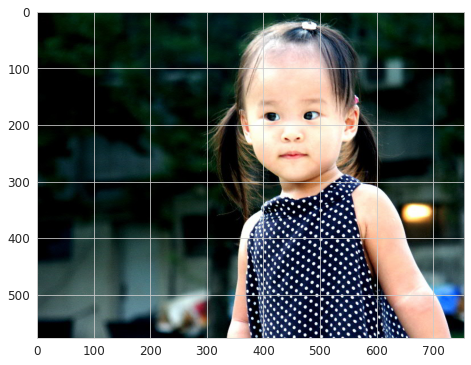

In [105]:
# Resize image to a width of 250
img = Image.open('../dataset/fsd4000/Original/im02000.jpg') 
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.show()

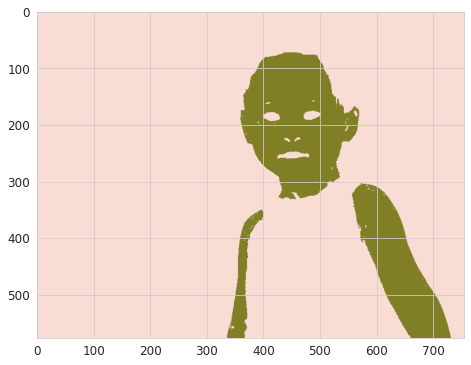

In [106]:
label = Image.open('../dataset/fsd4000/Skin/im02000.png')
plt.figure(figsize=(8, 6))
plt.imshow(label)
plt.show()

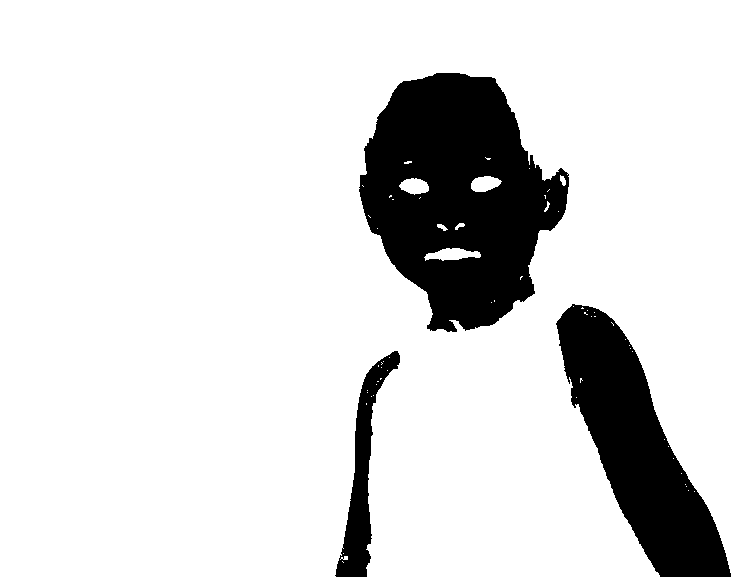

In [107]:
label = np.where(np.array(label)==1,255,0).astype(np.uint8)
Image.fromarray(label)

### View sample extracted using color range method

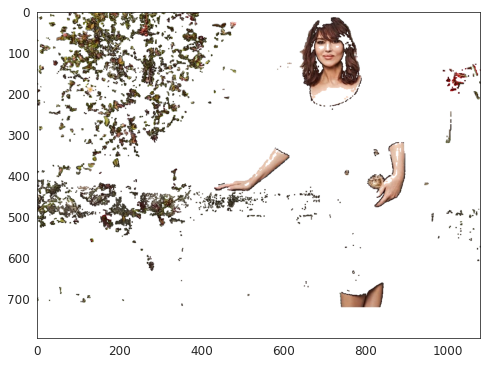

In [17]:
pred_label = extractSkin_HSV(cv2.imread('../data/ig/dolcegabbana/2021-03-27_17-00-57_UTC.jpg'))
#convert three channels to single 0/1 channel
#pred_label  = np.where(pred_label==0,1,0).astype(np.uint8) # any black will be removed and classified as non-skin
#pred_label  = np.sum(pred_label,2)
#pred_label  = np.where(pred_label==3,1,0).astype(np.uint8) # 0 skin

#pred_label_seg  = Image.fromarray(pred_label).convert('P')
#pred_label_seg.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))
#plt.imshow(pred_label_seg)
skin = cv2.cvtColor(pred_label,cv2.COLOR_BGR2RGB)

mask = np.all((skin >= [245, 245, 245])|(skin <= [10, 10, 10]), axis=-1)
mask = np.repeat(mask[:,:,np.newaxis],3,axis=2)
mx = ma.masked_array(skin,mask=mask)
a_color = list(map(round,mx.mean(axis=0).mean(axis=0).data))
mx = mx.filled(fill_value=255)

plt.imshow(mx)
#plt.savefig('../result1/figures/image_sample_dolcegabbana_naive.png', dpi=300,bbox_inches = 'tight')
plt.show()

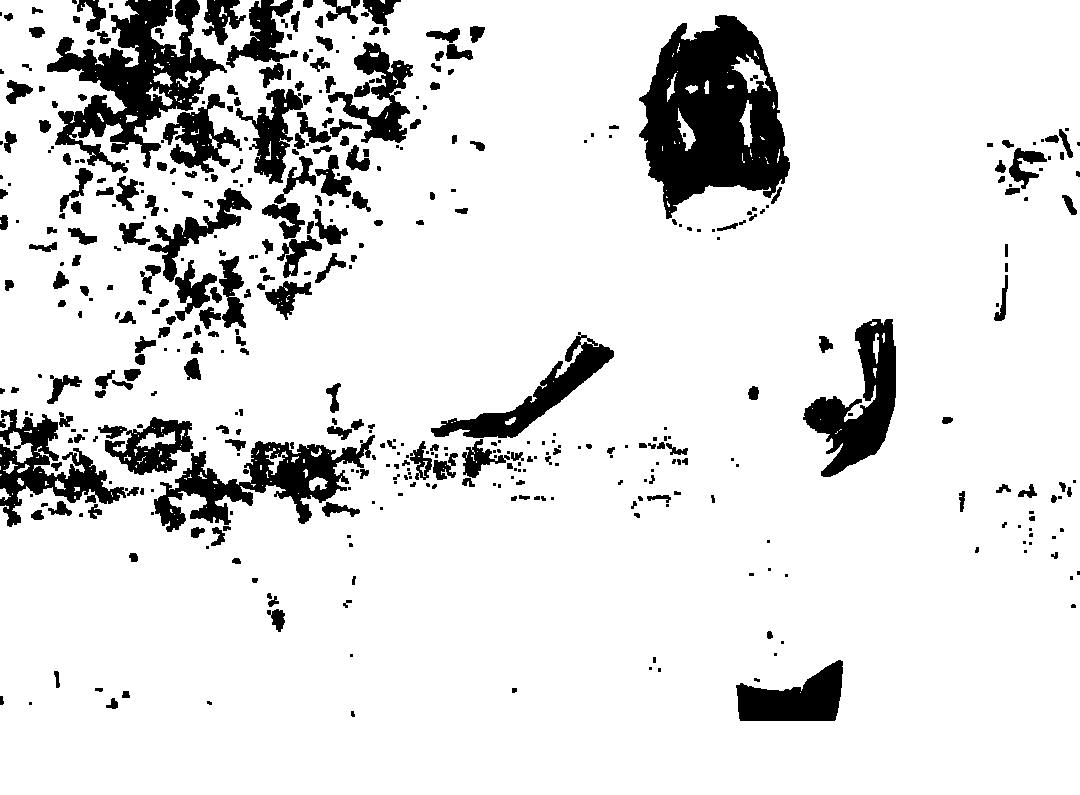

In [11]:
pred_label = np.where(pred_label==1,255,0).astype(np.uint8)
Image.fromarray(pred_label)

- From the figure, there are many pixels that are not skin, but filtered as skin because they have similar color as skin 

### Compute IoU on testing dataset - FSD
- this test dataset is also the dataset used for testing trained swin transformer

In [3]:
with open('../dataset/fsd4000/skin_splits/val.txt','r') as f:
    tests = f.readlines()
tests = [i.strip('\n')+'.jpg' for i in tests]

In [4]:
tests[0]

'im00975.jpg'

In [5]:
data_root = '../dataset/fsd4000'
img_dir = 'Original'
ann_dir = 'Skin'

IoUs = []
for img_f in tests:
    img_path = osp.join(data_root,img_dir,img_f)
    pred_label = extractSkin_RGB(cv2.imread(img_path))
    #convert three channels to single 0/1 channel
    pred_label  = np.where(pred_label==0,1,0).astype(np.uint8) # any black will be removed and classified as non-skin
    pred_label  = np.sum(pred_label,2)
    pred_label  = np.where(pred_label==3,1,0).astype(np.uint8) 
    pred_label  = np.where(pred_label==0,1,0).astype(np.uint8) # skin: 1
    
    #label
    label_path =  osp.join(data_root,ann_dir,img_f[0:-4]+'.png')
    label = np.array(Image.open(label_path))  
    label = np.where(label==0,1,0).astype(np.uint8) # skin: 1  
    
    if pred_label.shape!=label.shape:
        print('swap axes')
        pred_label = pred_label.reshape(label.shape)
    #iou
    intersection = np.logical_and(pred_label, label)
    union = np.logical_or(pred_label, label)
    IoUs.extend([np.sum(intersection) / np.sum(union)])


swap axes


In [6]:
iou = pd.DataFrame(IoUs,columns=['skin_iou'])

In [104]:
#iou.to_csv('../result/naive_skiniou_test.csv', header=True, index=False)

In [7]:
iou.describe()

,skin_iou
count,800.000000
mean,0.284146
std,0.175258
min,0.012381
25%,0.143958
50%,0.252371
75%,0.385537
max,0.924607


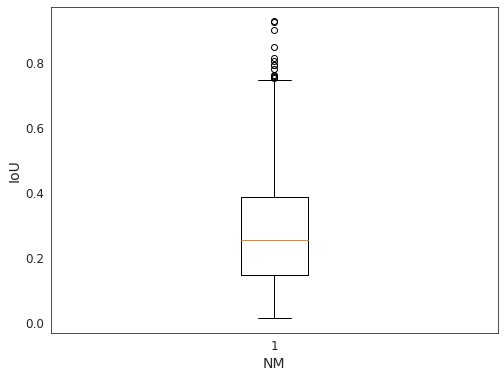

In [8]:
plt.figure(figsize=(8,6))
plt.boxplot(iou['skin_iou'])

plt.xlabel('NM')
plt.ylabel('IoU')
#plt.savefig(r'../results/naive_iou_boxplot.png',dpi=300,bbox_inches = 'tight')
plt.show()

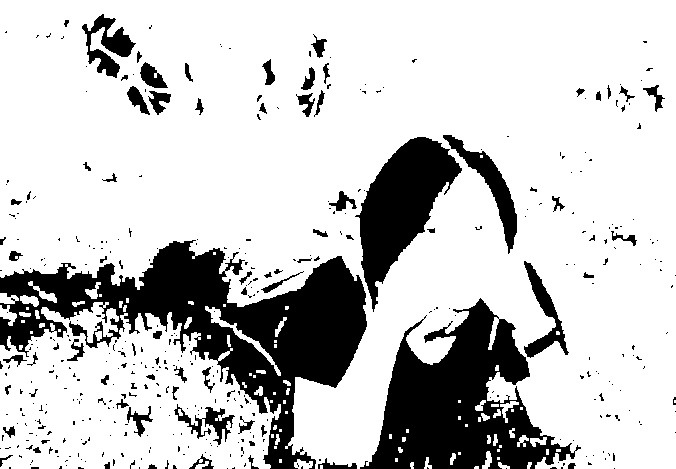

In [53]:
pred_label_ = np.where(pred_label==1,255,0).astype(np.uint8)
Image.fromarray(pred_label_)

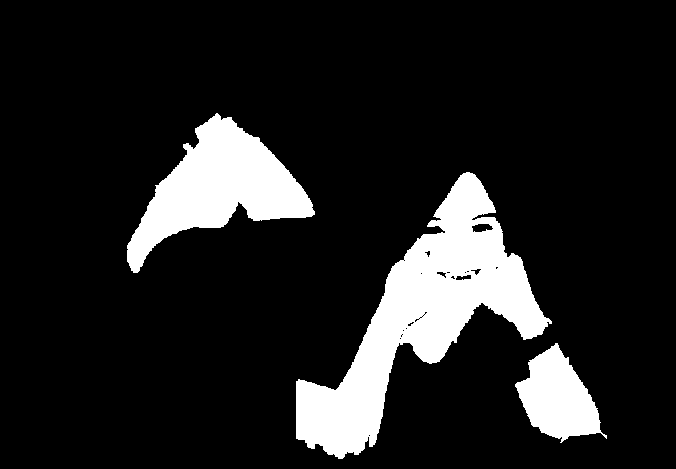

In [54]:
label_ = np.where(label==1,255,0).astype(np.uint8)
Image.fromarray(label_)